# Stereo Estimation


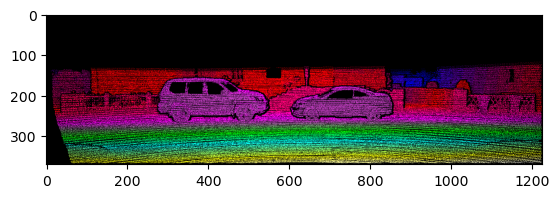

In [8]:
import matplotlib.pyplot as plt
from util import *

# load the data
leftI = load_image('data/000005_10_left_color.png')
rightI = load_image('data/000005_10_right_color.png')
dispI_gt = load_disp('data/000005_10_gt.png')
max_disp = np.max(dispI_gt)

plt.imshow(disp_to_color(dispI_gt, max_disp))

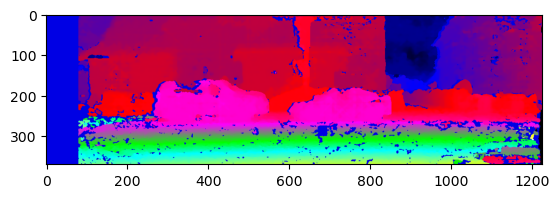

In [9]:
NUM_DISP = 80
WINDOW_SIZE = 7

stereo = cv2.StereoSGBM_create(minDisparity = 0,
                               numDisparities = NUM_DISP,
                               blockSize = WINDOW_SIZE,
                               P1 = 8*3*WINDOW_SIZE**2,
                               P2 = 32*3*WINDOW_SIZE**2,
                               disp12MaxDiff = 1,
                               uniquenessRatio = 10,
                               speckleWindowSize = 100,
                               speckleRange = 32)

dispI_est = stereo.compute(leftI, rightI).astype(np.float32) / 16.0
max_disp = np.max(dispI_est)

plt.imshow(disp_to_color(dispI_est, max_disp))

In [27]:
### KITTI parameters ###
f = 718.86 # focal point 
cx = 607.19 
cy = 185.22
B = 0.537 # Baseline 

# triangulate 3D Points
all_colors = cv2.cvtColor(leftI, cv2.COLOR_BGR2RGB)
# print(all_colors.shape)
# print(all_colors[0,0,:])
height, width = leftI.shape[:2]
# print(height, width)
def triangulate(dispI, fn): #dispI: disparity image, fn: dir for saving the map 
    points = []
    colors = []

    # compute the 3D points for the given disparity image and their corresponding colors
    # by implementing triangulation (back-projection)
    for x in range(width):
        for y in range(height):

            if dispI[y][x]<=0.0:
                continue 
                
            # calculating the depth 
#             print(dispI[x][y])
            depth = (B*f)/(dispI[y][x])
            p = (((x-cx)*depth)/f, ((y-cy)*depth)/f, depth)
            points.append(p)
#             print(all_colors[y,x,:])
            colors.append(all_colors[y,x,:])
    

    points = np.array(points)
    colors = np.array(colors)
    write2ply(points, colors, fn)
    
triangulate(dispI_gt, 'out/pts_gt.ply')
triangulate(dispI_est, 'out/pts_est.ply')

print('done!')

done!


Visualize the 3D point clouds using MeshLab or Open3D. Note that you might have to rotate the point cloud a little bit until you can make sense of it, especially with the estimated disparity map where there are outliers.

**Bonus**: Implement the outlier ratio metric of the KITTI to evaluate the estimation quantitatively.

In [30]:
import numpy as np
def compute_outlier_ratio(gt_dispI, est_dispI, threshold=3):
    disp_diff = np.abs(gt_dispI - est_dispI)
    outlier_mask = disp_diff > threshold
#     print(outlier_mask)
    outlier_ratio = np.mean(outlier_mask.astype(np.float32))
    return outlier_ratio

In [31]:
print(compute_outlier_ratio(dispI_gt , dispI_est))

0.6342952
